# Exploration of geographically weighted random forest classification modelling

To-do:
- [x] global model
- [x] model evaluation
- [x] bandwidth optimisation
- [x] feature importances
- [x] golden section bandwidth selection
- [x] other metrics than accuracy
- [x] generic support (logistic regression, gradient boosting)
- [x] dedicated classes
- [ ] local performance of models that do not support OOB
    - [x] with logistic regression I guess we can do predict_proba and measure those on the full sample directly
    - with gradient boosting we can't as the model has seen the data - might need to split to train/test to mimic OOB.
- [x] logistic regression local coefficients
- [x] (optionally) predict method

In [ ]:
import geopandas as gpd
import numpy as np
import pandas as pd
from geodatasets import get_path
from sklearn import metrics, preprocessing

from gwlearn.ensemble import GWGradientBoostingClassifier, GWRandomForestClassifier
from gwlearn.linear_model import GWLogisticRegression
from gwlearn.search import BandwidthSearch


Get sample data

In [2]:
gdf = gpd.read_file(get_path("geoda.ncovr"))

In [3]:
gdf.shape

(3085, 70)

In [4]:
# It is in the geographic coords in the  US and we need to work with distances. Re-project and use only points as the graph builder will require points anyway.
gdf = gdf.set_geometry(gdf.representative_point()).to_crs(5070)

In [5]:
y = gdf["FH90"] > gdf["FH90"].median()

### Random forest

In [6]:
gwrf = GWRandomForestClassifier(
    bandwidth=250,
    fixed=False,
    n_jobs=-1,
    keep_models=False,
)
gwrf.fit(
    gdf.iloc[:, 9:15],
    y,
    gdf.geometry,
)

Global OOB accuracy for the GW model measured based on OOB predictions from individual local trees.

In [7]:
gwrf.oob_score_

0.7640363636363636

In [8]:
gwrf.oob_precision_

0.7678219138798962

In [9]:
gwrf.oob_recall_

0.7628955516954913

In [10]:
gwrf.oob_balanced_accuracy_

np.float64(0.7640465361465598)

Local OOB accuracy.

<Axes: >

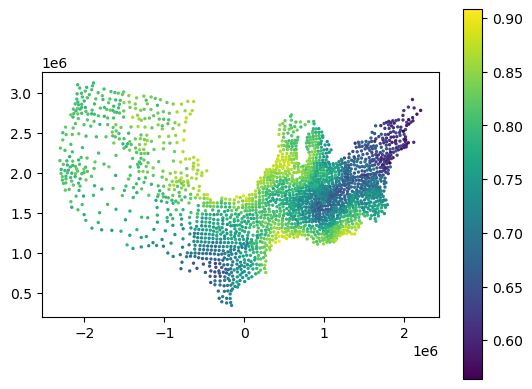

In [11]:
gdf.plot(gwrf.local_oob_score_, legend=True, s=2)

<Axes: >

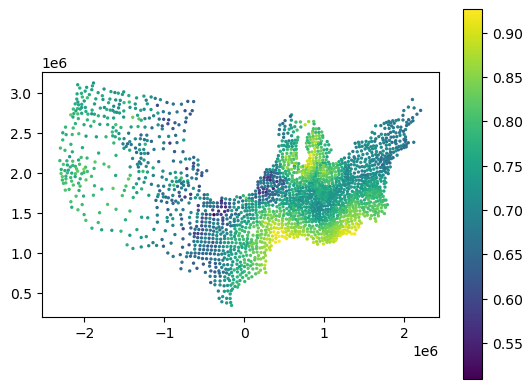

In [12]:
gdf.plot(gwrf.local_oob_precision_, legend=True, s=2)

<Axes: >

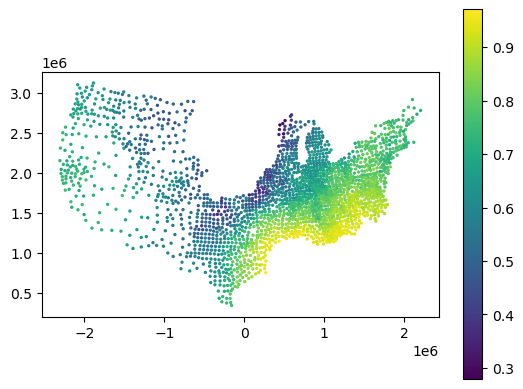

In [13]:
gdf.plot(gwrf.local_oob_recall_, legend=True, s=2)

<Axes: >

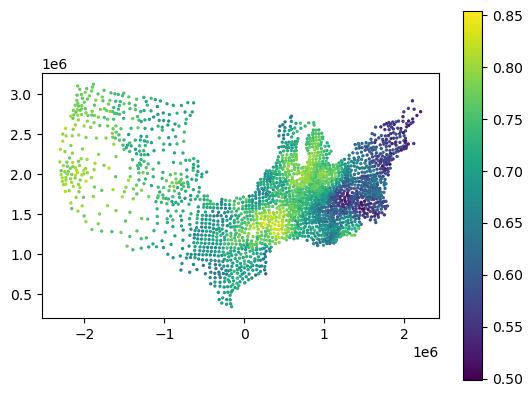

In [14]:
gdf.plot(gwrf.local_oob_balanced_accuracy_, legend=True, s=2)

<Axes: >

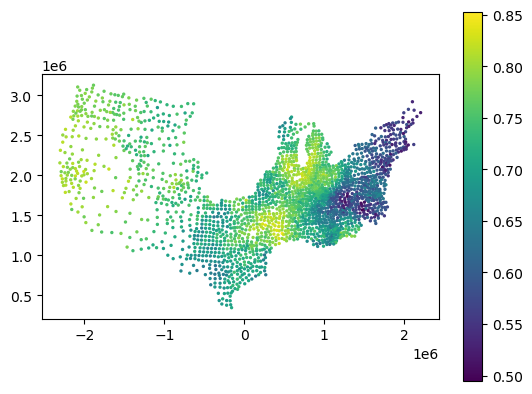

In [15]:
gdf.plot(gwrf.local_oob_f1_macro_, legend=True, s=2)

<Axes: >

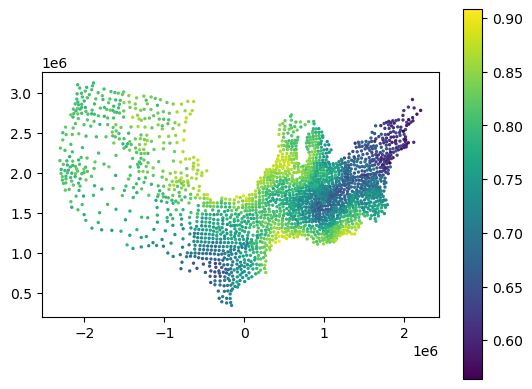

In [16]:
gdf.plot(gwrf.local_oob_f1_micro_, legend=True, s=2)

<Axes: >

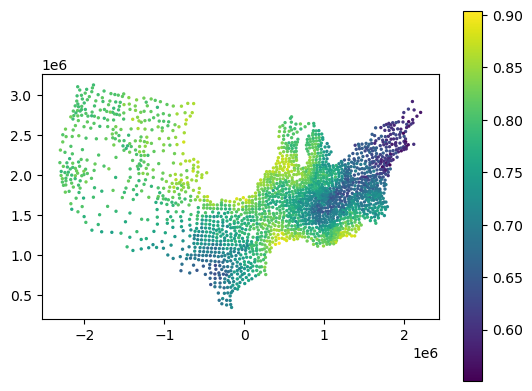

In [17]:
gdf.plot(gwrf.local_oob_f1_weighted_, legend=True, s=2)

<Axes: >

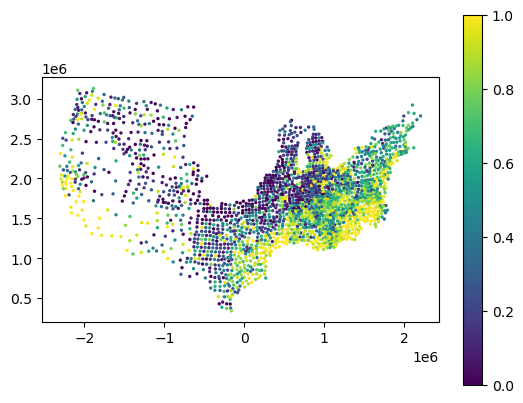

In [18]:
gdf.plot(gwrf.focal_proba_[True], legend=True, s=2)

<Axes: >

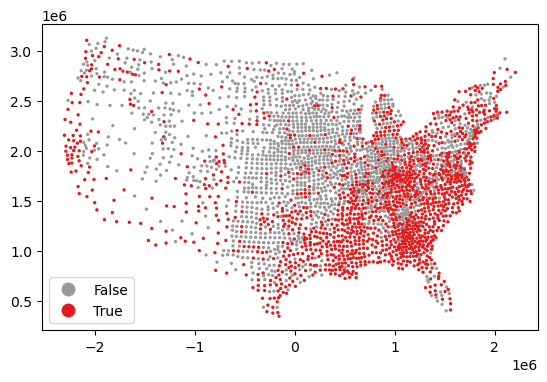

In [19]:
gdf.plot(y, legend=True, s=2, cmap="Set1_r")

Global accuracy for the GW model measured based on prediction of focals.

In [20]:
gwrf.score_

0.7675324675324675

F1 scores for the GW model measured based on prediction of focals. 

In [21]:
gwrf.f1_macro_, gwrf.f1_micro_, gwrf.f1_weighted_

(0.7674100288171037, 0.7675324675324675, 0.7676133232878964)

OOB score (accuracy) of the global model.

In [22]:
gwrf.global_model.oob_score_

0.7834683954619125

Get local feature importances.

In [23]:
gwrf.feature_importances_

,HR60,HR70,HR80,HR90,HC60,HC70
0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.139884,0.136771,0.127229,0.164681,0.206685,0.224750
2,0.169602,0.143187,0.128082,0.156054,0.213228,0.189848
3,0.134485,0.157993,0.128780,0.143277,0.210137,0.225327
4,0.145270,0.139416,0.127550,0.158895,0.184917,0.243953
...,...,...,...,...,...,...
3080,0.140749,0.092557,0.190372,0.101332,0.272964,0.202027
3081,0.153277,0.098518,0.153942,0.194368,0.234988,0.164906
3082,0.136436,0.210457,0.201628,0.218686,0.097278,0.135514
3083,0.154820,0.163920,0.193975,0.257641,0.108027,0.121618


<Axes: >

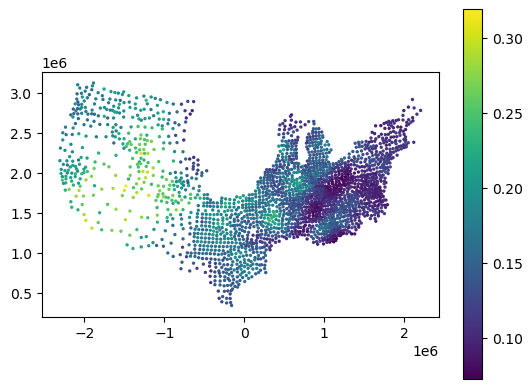

In [24]:
gdf.plot(gwrf.feature_importances_["HC60"], legend=True, s=2)

Compare to global feature importance.

In [25]:
gwrf.global_model.feature_importances_

array([0.13623077, 0.1469751 , 0.18856767, 0.19037982, 0.15016704,
       0.18767959])

### Gradient boosting

In [26]:
gwgb = GWGradientBoostingClassifier(
    bandwidth=250,
    fixed=False,
    n_jobs=-1,
    keep_models=False,
)
gwgb.fit(
    gdf.iloc[:, 9:15],
    y,
    gdf.geometry,
)

Global score (accuracy) for the GW model measured based on prediction of focals.

In [27]:
gwgb.score_

0.7541125541125541

F1 scores for the GW model measured based on prediction of focals. 

In [28]:
gwgb.f1_macro_, gwgb.f1_micro_, gwgb.f1_weighted_

(0.7539236654736193, 0.7541125541125541, 0.7541833873521547)

Get local feature importances.

In [29]:
gwgb.feature_importances_

,HR60,HR70,HR80,HR90,HC60,HC70
0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.176308,0.127630,0.061381,0.157109,0.155473,0.322099
2,0.183746,0.130184,0.062822,0.166335,0.121271,0.335642
3,0.152688,0.136632,0.074742,0.171089,0.068716,0.396133
4,0.173000,0.127535,0.076127,0.154761,0.114393,0.354184
...,...,...,...,...,...,...
3080,0.107378,0.051807,0.144954,0.050359,0.580163,0.065339
3081,0.090439,0.073503,0.135328,0.211356,0.453904,0.035471
3082,0.112123,0.191566,0.192371,0.314845,0.064285,0.124809
3083,0.146104,0.146674,0.160600,0.383174,0.053058,0.110391


<Axes: >

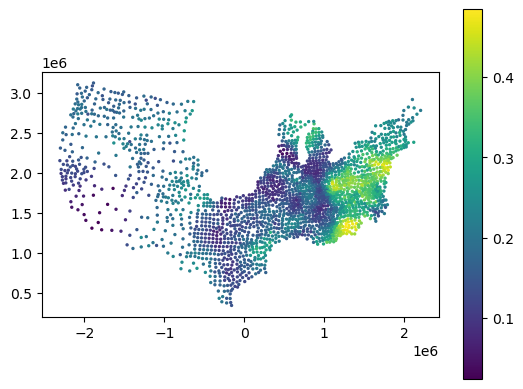

In [30]:
gdf.plot(gwgb.feature_importances_["HR90"], legend=True, s=2)

Compare to global feature importance.

In [31]:
gwgb.global_model.feature_importances_

array([0.05762984, 0.06003317, 0.12289142, 0.15117186, 0.21936903,
       0.38890468])

### Logistic regression

In [32]:
gwlr = GWLogisticRegression(
    bandwidth=900_000,
    fixed=True,
    n_jobs=-1,
    keep_models=True,
    max_iter=500,
)
gwlr.fit(
    pd.DataFrame(
        preprocessing.scale(gdf.iloc[:, 9:15]), columns=gdf.iloc[:, 9:15].columns
    ),
    gdf["FH90"] > gdf["FH90"].median(),
    gdf.geometry,
)

In [33]:
gwlr.score_

0.7911936704506364

In [34]:
gwlr.pred_f1_micro

0.7864280001426905

<Axes: >

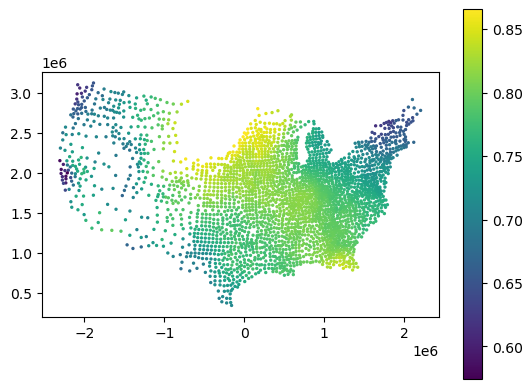

In [35]:
gdf.plot(gwlr.local_pred_f1_micro_, legend=True, s=2)

In [36]:
gwlr.f1_macro_, gwlr.f1_micro_, gwlr.f1_weighted_

(0.7911541287072663, 0.7911936704506364, 0.7912401319990963)

Local coefficients

In [37]:
gwlr.local_coef_

,HR60,HR70,HR80,HR90,HC60,HC70
0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.286802,0.123161,0.099993,0.359248,1.357041,0.864515
2,0.311253,0.157535,0.046688,0.273231,1.380707,0.857892
3,0.299757,0.198515,0.035917,0.216032,1.324819,0.895019
4,0.309365,0.149005,0.073854,0.276963,1.378795,0.840442
...,...,...,...,...,...,...
3080,0.084373,0.360897,0.506413,-0.027660,1.115072,0.724758
3081,0.118441,0.106981,0.573711,0.347592,1.512293,0.827530
3082,-0.115461,0.503123,0.322601,0.657267,1.764582,1.215657
3083,-0.142727,0.468729,0.371395,0.609215,2.124454,1.390968


<Axes: >

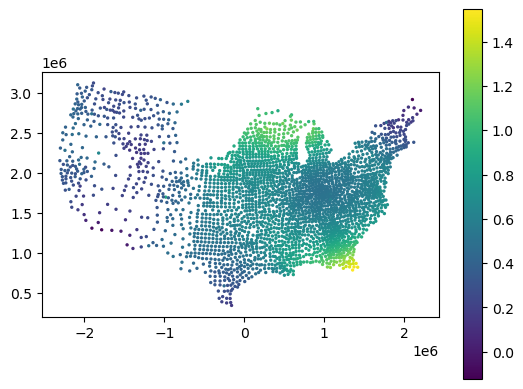

In [38]:
gdf.plot(gwlr.local_coef_["HR90"], legend=True, s=2)

Local intercepts

<Axes: >

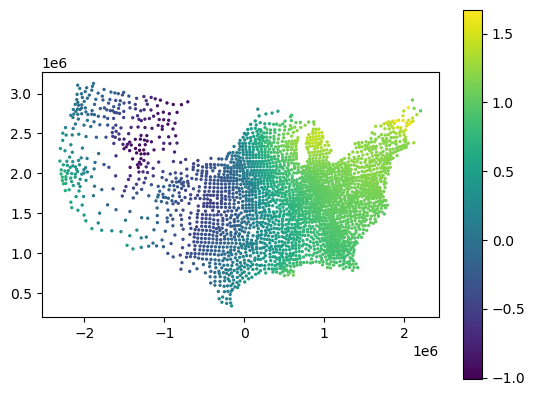

In [39]:
gdf.plot(gwlr.local_intercept_, s=2, legend=True)

## Bandwidth search

Golden section search with a fixed distance bandwidth.

In [40]:
search = BandwidthSearch(
    GWRandomForestClassifier,
    fixed=True,
    n_jobs=-1,
    search_method="golden_section",
    criterion="aic",
    max_iterations=10,
    min_bandwidth=250_000,
    max_bandwidth=2_000_000,
    verbose=True,
)
search.fit(
    gdf.iloc[:, 9:15],
    y,
    gdf.geometry,
)

Fitting bandwidth: 918447.5
-0.46377759397516044 2918 6
Bandwidth: 918447.5, Score: 12.928
Fitting bandwidth: 1331552.5
-0.5441836880805809 3073 6
Bandwidth: 1331552.5, score: 13.088
Fitting bandwidth: 663120.61
-0.5344611051381088 2713 6
Bandwidth: 663120.61, Score: 13.069
Fitting bandwidth: 1076231.57
-0.4947366892306055 2990 6
Bandwidth: 1076231.57, score: 12.989
Fitting bandwidth: 820916.6
-0.5321403198739965 2866 6
Bandwidth: 820916.6, Score: 13.064
Fitting bandwidth: 978708.91
-0.5518515725332722 2946 6
Bandwidth: 978708.91, score: 13.104
Fitting bandwidth: 881188.53
-0.5298489555392377 2898 6
Bandwidth: 881188.53, Score: 13.060
Fitting bandwidth: 941459.05
-0.5048175122259323 2928 6
Bandwidth: 941459.05, score: 13.010
Fitting bandwidth: 904210.06
-0.4864186275836341 2912 6
Bandwidth: 904210.06, Score: 12.973
Fitting bandwidth: 927231.06
-0.5070232480375556 2922 6
Bandwidth: 927231.06, score: 13.014
Fitting bandwidth: 913003.39
-0.5073638158224911 2912 6
Bandwidth: 913003.39, Sco

Get the optimal one.

In [41]:
search.optimal_bandwidth

np.float64(918437.8534390595)

Golden section search with an adaptive KNN bandwidth.

In [42]:
search = BandwidthSearch(
    GWLogisticRegression,
    fixed=False,
    n_jobs=-1,
    search_method="interval",
    min_bandwidth=10,
    max_bandwidth=3084,
    interval=200,
    criterion="aic",
    verbose=True,
    max_iter=500,  # passed to log regr
)
search.fit(
    pd.DataFrame(
        preprocessing.scale(gdf.iloc[:, 9:15]), columns=gdf.iloc[:, 9:15].columns
    ),
    y,
    gdf.geometry,
)

/Users/martin/dev/uscuni/gwlearn/gwlearn/bandwidth_search.py:93: UserWarning: y at locations Index([  21,   35,   36,   37,   40,   52,   53,   83,   84,  101,
       ...
       2933, 2935, 2945, 2946, 2958, 2959, 2960, 2972, 3076, 3084],
      dtype='int64', name='focal', length=667) is invariant.


-0.629958586572012 1859 6
Bandwidth: 10.00, score: 13.260
-0.5171936614116868 2283 6
Bandwidth: 210.00, score: 13.034
-0.48623171428322803 2504 6
Bandwidth: 410.00, score: 12.972
-0.4602374240580187 2720 6
Bandwidth: 610.00, score: 12.920
-0.44345280277184357 2935 6
Bandwidth: 810.00, score: 12.887
-0.43719177935367515 3085 6
Bandwidth: 1010.00, score: 12.874
-0.4369932011436922 3085 6
Bandwidth: 1210.00, score: 12.874
-0.4368468798500136 3085 6
Bandwidth: 1410.00, score: 12.874
-0.43679796166550977 3085 6
Bandwidth: 1610.00, score: 12.874
-0.4369199248040506 3085 6
Bandwidth: 1810.00, score: 12.874
-0.43719306283176784 3085 6
Bandwidth: 2010.00, score: 12.874
-0.4378176959496875 3085 6
Bandwidth: 2210.00, score: 12.876
-0.43888290830882337 3085 6
Bandwidth: 2410.00, score: 12.878
-0.4403941857777251 3085 6
Bandwidth: 2610.00, score: 12.881
-0.44262228915487023 3085 6
Bandwidth: 2810.00, score: 12.885
-0.44646119305842685 3085 6
Bandwidth: 3010.00, score: 12.893


AttributeError: 'BandwidthSearch' object has no attribute 'scores'

In [ ]:
search.scores_.idxmin()

In [ ]:
search.oob_scores.plot()

Get the optimal one.

In [ ]:
search.optimal_bandwidth

## Prediction

If you want to use the model for prediction, all the local models need to be retained. That may require significant memory for RF.

In [ ]:
gwlr = GWLogisticRegression(
    bandwidth=1210,
    fixed=False,
    n_jobs=-1,
    # search_method="golden_section",
    # criterion="aic",
    # max_iterations=10,
    # tolerance=0.1,
    verbose=True,
    max_iter=500,  # passed to log regr
    measure_performance=False,
)
gwlr.fit(
    pd.DataFrame(
        preprocessing.scale(gdf.iloc[:, 9:15]), columns=gdf.iloc[:, 9:15].columns
    ),
    gdf["FH90"] > gdf["FH90"].median(),
    gdf.geometry,
)

In [ ]:
all_data = pd.DataFrame(
    preprocessing.scale(gdf.iloc[:, 9:15]), columns=gdf.iloc[:, 9:15].columns
)

Predict probabilities

In [ ]:
pp = gwlr.predict_proba(all_data.iloc[:10], geometry=gdf.geometry.iloc[:10])
pp

Predict label (taking max of probabilities)

In [ ]:
gwlr.predict(all_data.iloc[5:10], geometry=gdf.geometry.iloc[5:10])